In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support, make_scorer, recall_score, f1_score, confusion_matrix, precision_score, balanced_accuracy_score
from sklearn.metrics import fbeta_score, classification_report


from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from libs.loader import load_malicious, load_jobchange
         

from sklearn.model_selection import learning_curve, validation_curve

In [10]:
#Some labels
ds_labels = {1:'dataset-01: Malicious Hack', 2:'dataset-02: Job Change'}

#Load the two datset
job_data = load_jobchange()
mal_data = load_malicious()


In [23]:


scorer_job = make_scorer(f1_score)
scorer_mal = scorer = make_scorer(recall_score)

mlp_mal = MLPClassifier(hidden_layer_sizes=(158,), max_iter=500, random_state=0)
mlp_job =  MLPClassifier(hidden_layer_sizes=(7,),max_iter=500,random_state=0 )




##  Hyperparam stuff

In [15]:
def eval_hyperparam(estimator, data, param_name='nothing', range_list=[], range_override=[], scorer=None):
    strat_cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    X,y = data
    
    dt_train_scores,dt_test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=range_list,
        scoring=scorer, cv=strat_cv, n_jobs=-1)
    
    train_scores_mean = np.mean(dt_train_scores, axis=1)
    test_scores_mean = np.mean(dt_test_scores, axis=1)
    x_vals = range_override  if len(range_override) > 0 else range_list
    
    df_1 = pd.DataFrame({'x':x_vals,'train':train_scores_mean,'test':test_scores_mean} )
#     print(df_1)
    return df_1
    

In [48]:
def plot(df_1, metric_name, x_label, title, ds_id, figsize = [7,5], show=False):
    fig = plt.figure(figsize=figsize, facecolor='w')
    axs = fig.add_subplot(111)
    axs.plot(df_1['x'], df_1['train'], label='Train', linewidth=0.75)
    axs.plot(df_1['x'], df_1['test'], label='Validation', linewidth=0.75)
    axs.legend(); axs.set_ylabel("Metric: %s"%metric_name); axs.set_xlabel(x_label)
    title_out = "MLP Hyperparameter:\n%s\n%s"%(title, ds_labels[ds_id])
    axs.set_title(title_out)
    if show:
        plt.show()
    fig.savefig('plots/mlp_%d_hyper_%s.png'%(ds_id,x_label),bbox_inches='tight')
    plt.close(fig=fig)

In [16]:
arr = np.logspace(0.5, 2.4, num=20))
variable_layers_size =arr.astype('int32')

hidden_layer_range = [(v,) for v in variable_layers_size]

In [24]:
df_1 = eval_hyperparam(mlp_mal, mal_data, param_name='hidden_layer_sizes', range_list=hidden_layer_range, range_override=variable_layers_size, scorer=scorer_mal)

arr2 = np.logspace(0.5, 2.4, num=20)
variable_layers_size2 =arr2.astype('int32')
hidden_layer_range2 = [(v,) for v in variable_layers_size2]
df_2 = eval_hyperparam(mlp_job, job_data, param_name='hidden_layer_sizes', range_list=hidden_layer_range2, range_override=variable_layers_size2, scorer=scorer_job)

print('done')

done


In [49]:
plot(df_1, 'Recall', 'hidden_layer_size', 'Hidden Layer-1 Size', 1,show=False)
plot(df_2, 'F1 Score', 'hidden_layer_size', 'Hidden Layer-1 Size', 2,show=False)

## Try activation hyper param - Dataset-01 Malicious Hacks


In [32]:
# activation{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}
X_mal_train, y_mal_train = mal_data
strat_cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

range_list=['identity', 'logistic', 'tanh', 'relu']
mlp_train_scores, mlp_test_scores = validation_curve(
    mlp_mal, X_mal_train, y_mal_train, param_name="activation", param_range=range_list,
    scoring=scorer, cv=strat_cv, n_jobs=-1)
print("done")

done


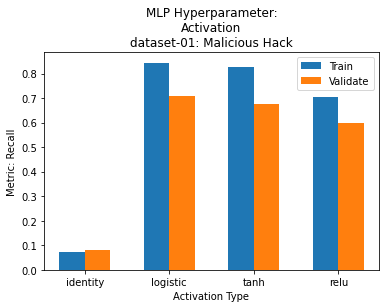

In [53]:
range_list_activation_mal=['identity', 'logistic', 'tanh', 'relu']
train_scores_mean = np.mean(mlp_train_scores, axis=1)
test_scores_mean = np.mean(mlp_test_scores, axis=1)
df_3 = pd.DataFrame({'x':range_list_activation_mal,'train':train_scores_mean,'test':test_scores_mean} )


def plot_bar(df):
    
    N=len(df['x']); ind = np.arange(N);width = 0.3
    fig = plt.figure()
    axs = fig.add_subplot(111)
    
    axs.bar(ind, df['train'], width, label='Train')
    axs.bar(ind+width, df['test'], width,label='Validate')
    axs.set_xticks(ind + width / 2)
    axs.set_xticklabels( df['x'] )
    axs.legend(); axs.set_ylabel("Metric: Recall"); axs.set_xlabel("Activation Type")
    
    title = "MLP Hyperparameter:\nActivation\n%s" % ds_labels[1]
    axs.set_title(title)
    plt.show()
    fig.savefig('plots/mlp_1_hyper_activation.png',bbox_inches='tight')
    plt.close(fig=fig)
    
    
plot_bar(df_3)

## Iteration graph

In [ ]:
## Plot iterations

# range_list_iter = np.linspace(1, 600, 15).astype('int32')
range_list_iter = np.linspace(1, 700, 15).astype('int32')

mlp_mal_activation = MLPClassifier(hidden_layer_sizes=(158,), activation='logistic', max_iter=500, random_state=0)

df_4 = eval_hyperparam(mlp_mal_activation, mal_data, param_name='max_iter', range_list=range_list_iter,  scorer=scorer_mal)
df_5 = eval_hyperparam(mlp_job, job_data, param_name='max_iter', range_list=range_list_iter,  scorer=scorer_job)
print("done")


In [50]:
plot(df_4, 'Recall', 'iteration_count', 'Iteration Count', 1,show=False)
plot(df_5, 'F1 Score', 'iteration_count', 'Iteration Count', 2,show=False)

## Hyperparameter for Data-set-2  'sgd' init_learning_rage

In [54]:
mlp_target_sgd =  MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, solver='sgd', learning_rate='invscaling',
                        momentum=0.6, learning_rate_init=0.00005, alpha=0.0016444444444444447, random_state=0 )

In [55]:
range_list_sgd = np.linspace(0.00005, 0.005,20)

In [60]:

df_6 =  eval_hyperparam(mlp_target_sgd, job_data, param_name='learning_rate_init', range_list=range_list_sgd,  scorer=scorer_job)
print("done")

done


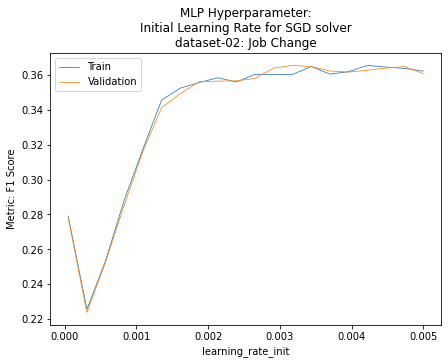

In [61]:
plot(df_6, 'F1 Score', 'learning_rate_init', 'Initial Learning Rate for SGD solver', 2,show=True)